In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')
import os
import datetime
import numpy as np
import dill as pickle
import random
import sys
import seaborn as sns
import math
from matplotlib import rcParams
rcParams['figure.figsize'] = 25, 10
from collections import OrderedDict
from matplotlib.lines import Line2D
from pylab import rcParams
from collections import Counter
from itertools import combinations
from sklearn.decomposition import TruncatedSVD
from shutil import copyfile
import scipy

np.random.seed(0)
random.seed(0)
now = datetime.datetime.now().strftime("%B_%d_%Y_%H_%M_%S")
workingdirectory = os.popen('git rev-parse --show-toplevel').read()[:-1]
sys.path.append(workingdirectory)
os.chdir(workingdirectory)

from codes.experimentclasses.AtomicRegression2 import AtomicRegression
from codes.otherfunctions.get_dictionaries import get_all_atoms_4
from codes.flasso.Replicate import Replicate
from codes.geometer.RiemannianManifold import RiemannianManifold
from codes.geometer.TangentBundle import TangentBundle
from codes.geometer.ShapeSpace import ShapeSpace
from codes.flasso.GradientGroupLasso import batch_stream, get_sr_lambda_sam_parallel
from codes.otherfunctions.get_grads import get_grads3

n = 50000 #number of data points to simulate
nsel = 100 #number of points to analyze with lasso
n_neighbors = 1000 #number of neighbors in megaman
m = 3 #number of embedding dimensions (diffusion maps)
diffusion_time = 1. #embedding radius
dim = 2 #manifold dimension
dimnoise = 2 #manifold dimension (not in mflasso paper)
cores = 3 
nreps = 5
natoms = 9

savename = 'ethanol_021521'
savefolder = 'ethanol'
data_wd = '/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/'

experiment = AtomicRegression(natoms)
experiment.m = m
experiment.dim = dim
experiment.dnoise = dim
experiment.nreps = nreps
experiment.nsel = nsel
experiment.atoms3, experiment.da = experiment.get_atoms_3()
experiment.atoms4,experiment.p = get_all_atoms_4(natoms)

data_wd = '/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/'
data_xyz_loaded = scipy.io.loadmat(data_wd + '/untracked_data/chemistry_data/ethanol.mat')
angle_indices = np.load(data_wd + '/untracked_data/chemistry_data/ethanolindices022119.npy')
experiment.positions =  data_xyz_loaded['R'][angle_indices]
filename_angles = data_wd + '/untracked_data/chemistry_data/ethanolangles022119.npy'
data = np.arccos(np.reshape(np.load(filename_angles), (50000, experiment.da)))

experiment.M = RiemannianManifold(data, dim)#experiment.load_data(workingdirectory = data_wd)
experiment.svd = TruncatedSVD(n_components=50)
experiment.Mpca = RiemannianManifold(experiment.svd.fit_transform(experiment.M.data), dim)
experiment.Mpca.geom = experiment.Mpca.compute_geom(diffusion_time, n_neighbors)
experiment.N = experiment.Mpca.get_embedding3(experiment.Mpca.geom, m, diffusion_time, dim)



/Users/samsonkoelle/manifoldflasso_jmlr


0
1
2
3
4
5


Text(0.5, 0.98, 'Top 6 coordinates in Ethanol')

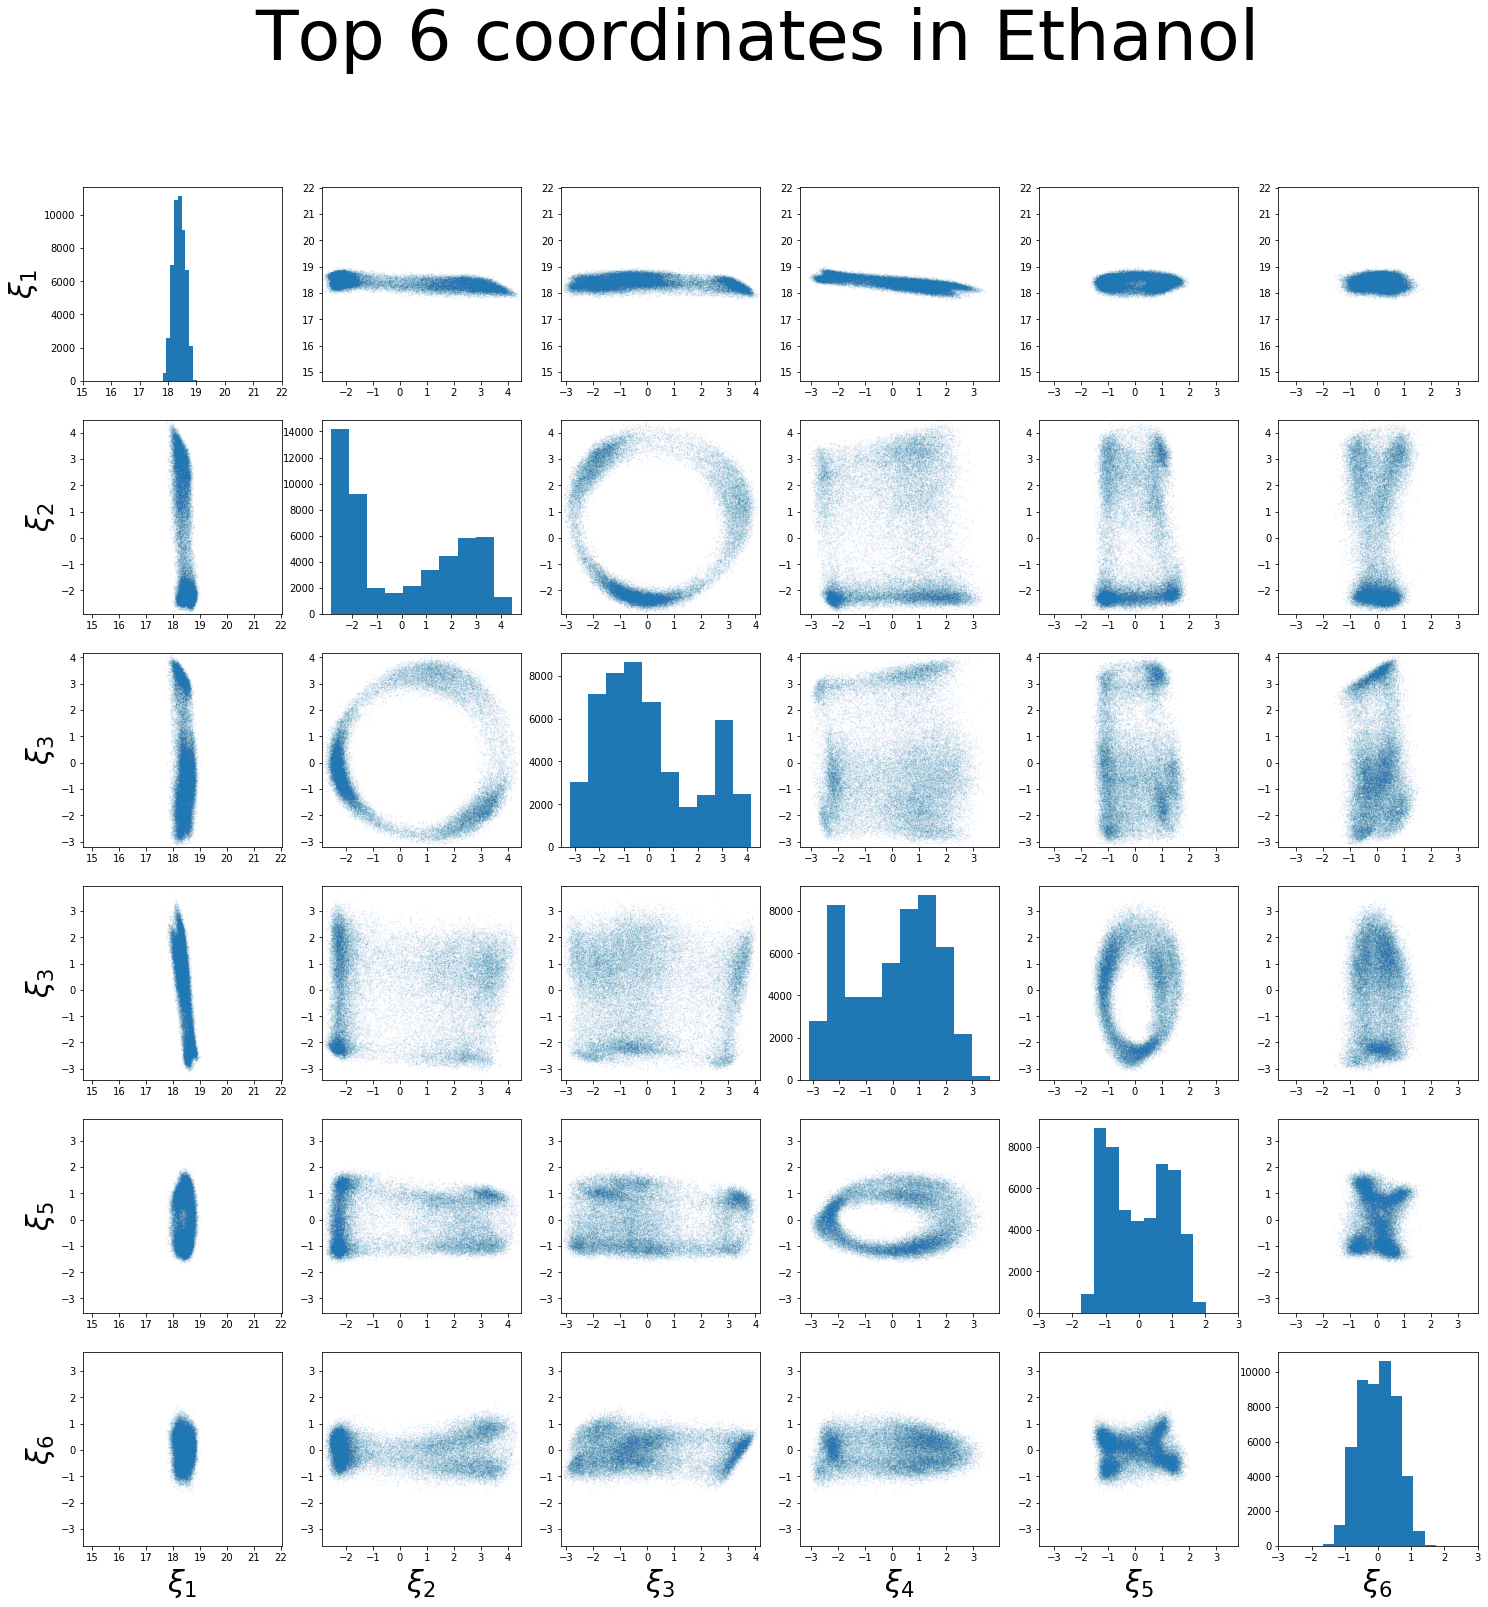

In [2]:
data = experiment.N.data

s = 100
alpha = .5
fig, axes = plt.subplots(6,6, figsize = (25,25))

xmins = np.zeros(6)
xmaxs = np.zeros(6)
xmeans = np.zeros(6)
for d in range(6):
    xmins[d] = experiment.Mpca.data[:,d].min()
    xmaxs[d] = experiment.Mpca.data[:,d].max()    
    xmeans[d] = (xmins[d] +  xmaxs[d]) / 2

gap = (xmaxs - xmins).max()

for d in range(6):
    xmins[d] = xmeans[d] - gap / 2 #experiment.Mpca.data[:,d].min()
    xmaxs[d] = xmeans[d] + gap / 2  #experiment.Mpca.data[:,d].max()    
    #xmeans[d] = (xmins[d] +  xmaxs[d]) / 2
    


for d in range(6):
    print(d)
    for e in range(6):
        xticks = list(range(math.ceil(xmins[d]), math.ceil(xmaxs[d])))
        yticks = list(range(math.ceil(xmins[e]), math.ceil(xmaxs[e])))
        if d != e:
            axes[e,d].scatter(experiment.Mpca.data[:,d],experiment.Mpca.data[:,e], s = .1, alpha = .1)
            axes[e,d].set_xlim(xmins[d], xmaxs[d])
            axes[e,d].set_ylim(xmins[e], xmaxs[e])
            axes[e,d].set_xticks(xticks)
            axes[e,d].set_yticks(yticks)
            #axes[d,e].set_xticklabels([])
            #axes[d,e].set_yticklabels([])
            #axes[d,e].set_xticks([])
            #axes[d,e].set_yticks([])
        if d == e:
            #axes[d,e].set_xticklabels([])
            #axes[d,e].set_yticklabels([])
            #axes[d,e].set_xticks([])
            #axes[d,e].set_yticks([])
            axes[d,e].hist(experiment.Mpca.data[:,d])
            axes[e,d].set_xticks(xticks)
    
axes[5,0].set_xlabel(r'$\xi_{1}$', fontsize= 30)
axes[5,1].set_xlabel(r'$\xi_{2}$', fontsize= 30)
axes[5,2].set_xlabel(r'$\xi_{3}$', fontsize= 30)
axes[5,3].set_xlabel(r'$\xi_{4}$', fontsize= 30)
axes[5,4].set_xlabel(r'$\xi_{5}$', fontsize= 30)
axes[5,5].set_xlabel(r'$\xi_{6}$', fontsize= 30)

axes[0,0].set_ylabel(r'$\xi_{1}$', fontsize= 30)
axes[1,0].set_ylabel(r'$\xi_{2}$', fontsize= 30)
axes[2,0].set_ylabel(r'$\xi_{3}$', fontsize= 30)
axes[3,0].set_ylabel(r'$\xi_{3}$', fontsize= 30)
axes[4,0].set_ylabel(r'$\xi_{5}$', fontsize= 30)
axes[5,0].set_ylabel(r'$\xi_{6}$', fontsize= 30)


fig = plt.gcf()
fig.suptitle('Top 6 coordinates in Ethanol', fontsize=70)

#plt.savefig('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/Figures/figure_for_jmlr/eth_xi_pairplot')
#axes[d,e].set_axis_off()#axes.set_   

In [3]:
from codes.otherfunctions.get_dictionaries import get_atoms_4

In [4]:
ii_eth = np.asarray([0,0,0,0,1,1,1,2]) # atom adjacencies for dihedral angle computation
jj_eth = np.asarray([1,2,3,4,5,6,7,8])
atoms4_eth,p = get_atoms_4(9,ii_eth,jj_eth)
g1 = experiment.get_g_full_sub(experiment.M.data, atoms4_eth[0])
g2 = experiment.get_g_full_sub(experiment.M.data, atoms4_eth[9])

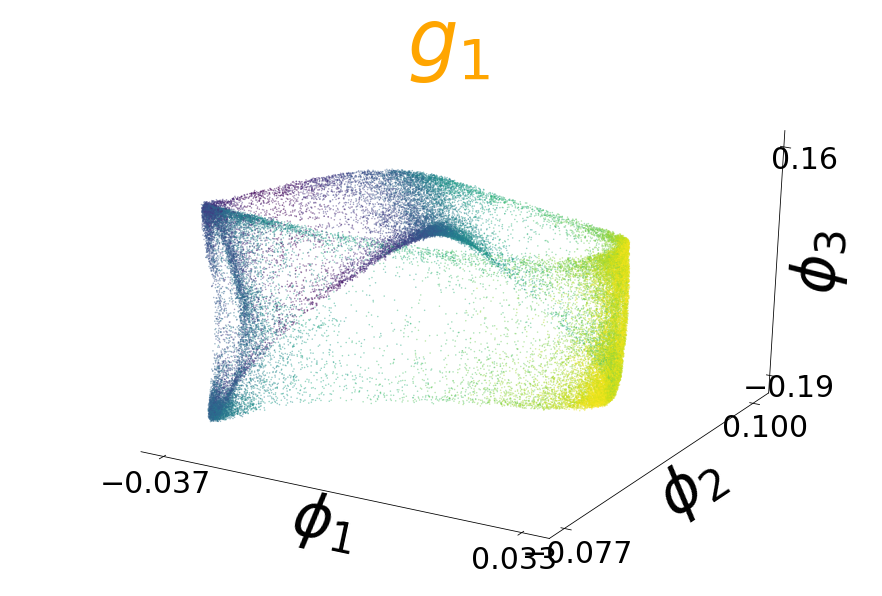

In [5]:
%matplotlib inline
data = experiment.N.data
axes = [0,1,2]
s = 100
alpha = .5

fig, axs = plt.subplots(1,1, figsize = (15,10))

axs.set_axis_off()
data = experiment.N.data
axes = [0,1,2]
s = 1
alpha = .5
selected_points = list(range(50000))
x = data[:, 0][selected_points]
y = data[:, 1][selected_points]
z = data[:, 2][selected_points]

ax = fig.add_subplot(1,1,1, projection='3d')

ax.scatter(x, y, z, c = g1, s=s, alpha=alpha, marker='.',vmin=0,vmax=np.pi)
ax.set_xlabel(r'$\phi_1$', fontsize = 60)
ax.set_ylabel(r'$\phi_2$', fontsize = 60)
ax.set_zlabel(r'$\phi_3$', fontsize = 60)

ax.set_title(r'$g_{1}$', fontsize = 80, color = 'orange')

xmin = np.float(np.format_float_positional(data[:, 0][selected_points].min(), precision=2, fractional=False))
xmax = np.float(np.format_float_positional(data[:, 0][selected_points].max(), precision=2, fractional=False))
ymin = np.float(np.format_float_positional(data[:, 1][selected_points].min(), precision=2, fractional=False))
ymax = np.float(np.format_float_positional(data[:, 1][selected_points].max(), precision=2, fractional=False))
zmin = np.float(np.format_float_positional(data[:, 2][selected_points].min(), precision=2, fractional=False))
zmax = np.float(np.format_float_positional(data[:, 2][selected_points].max(), precision=2, fractional=False))
ax.set_xticks([xmin, xmax])
ax.set_yticks([ymin, ymax])
ax.set_zticks([zmin, zmax])
ax.tick_params(labelsize=30)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# make the grid lines transparent
ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)
#plt.savefig('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/Figures/figure_for_jmlr/eth_groundtruth_g1')

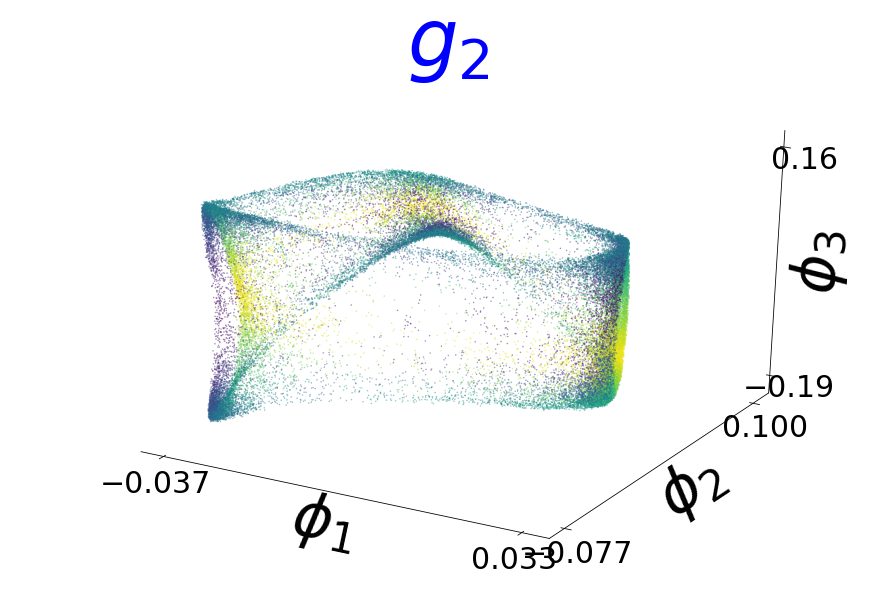

In [6]:
%matplotlib inline
data = experiment.N.data
axes = [0,1,2]
s = 100
alpha = .5

fig, axs = plt.subplots(1,1, figsize = (15,10))

axs.set_axis_off()
data = experiment.N.data
axes = [0,1,2]
s = 1
alpha = .5
selected_points = list(range(50000))
x = data[:, 0][selected_points]
y = data[:, 1][selected_points]
z = data[:, 2][selected_points]

ax = fig.add_subplot(1,1,1, projection='3d')

ax.scatter(x, y, z, c = g2, s=s, alpha=alpha, marker='.',vmin=0,vmax=np.pi)
ax.set_xlabel(r'$\phi_1$', fontsize = 60)
ax.set_ylabel(r'$\phi_2$', fontsize = 60)
ax.set_zlabel(r'$\phi_3$', fontsize = 60)

ax.set_title(r'$g_{2}$', fontsize = 80, color = 'blue')

xmin = np.float(np.format_float_positional(data[:, 0][selected_points].min(), precision=2, fractional=False))
xmax = np.float(np.format_float_positional(data[:, 0][selected_points].max(), precision=2, fractional=False))
ymin = np.float(np.format_float_positional(data[:, 1][selected_points].min(), precision=2, fractional=False))
ymax = np.float(np.format_float_positional(data[:, 1][selected_points].max(), precision=2, fractional=False))
zmin = np.float(np.format_float_positional(data[:, 2][selected_points].min(), precision=2, fractional=False))
zmax = np.float(np.format_float_positional(data[:, 2][selected_points].max(), precision=2, fractional=False))
ax.set_xticks([xmin, xmax])
ax.set_yticks([ymin, ymax])
ax.set_zticks([zmin, zmax])
ax.tick_params(labelsize=30)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# make the grid lines transparent
ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)
#plt.savefig('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/Figures/figure_for_jmlr/eth_groundtruth_g2')

In [13]:
from codes.flasso.Replicate import get_support_indices2d,get_detected_values2d
from codes.plotting.utils import get_ordered_axes, get_names,get_cmap

In [14]:
with open('/Users/samsonkoelle/manifoldflasso_jmlr/untracked_data/embeddings/ethanol/ethanol_0219_full_brute.pkl' ,
         'rb') as file:
     supports_brute = pickle.load(file)

subset_brute = np.unique(np.concatenate(list(supports_brute.values())) )
toplot_brute = get_support_indices2d(subset_brute, supports_brute,nreps)
names_brute = get_names(subset_brute)
colors_brute = get_cmap(subset_brute)

In [15]:
gb= {}
for b in range(len(subset_brute)):
    print(b)
    gb[b] = experiment.get_g_full_sub(experiment.M.data, experiment.atoms4[subset_brute[b]])

0
1
2
3
4
5
6
7
8
9
10
11
12
13


In [ ]:
with open('/Users/samsonkoelle/manifoldflasso_jmlr/untracked_data/embeddings/ethanol/ethanol_0223_fullreplicates_bruteg.pkl' ,
         'wb') as file:
     pickle.dump(gb, file)


In [17]:
import matplotlib as mpl
mpl.style.use('default')

1 1 1
1 2 2
1 3 3
1 4 4
2 1 5
2 2 6
2 3 7
2 4 8
3 1 9
3 2 10
3 3 11
3 4 12
4 1 13
4 2 14


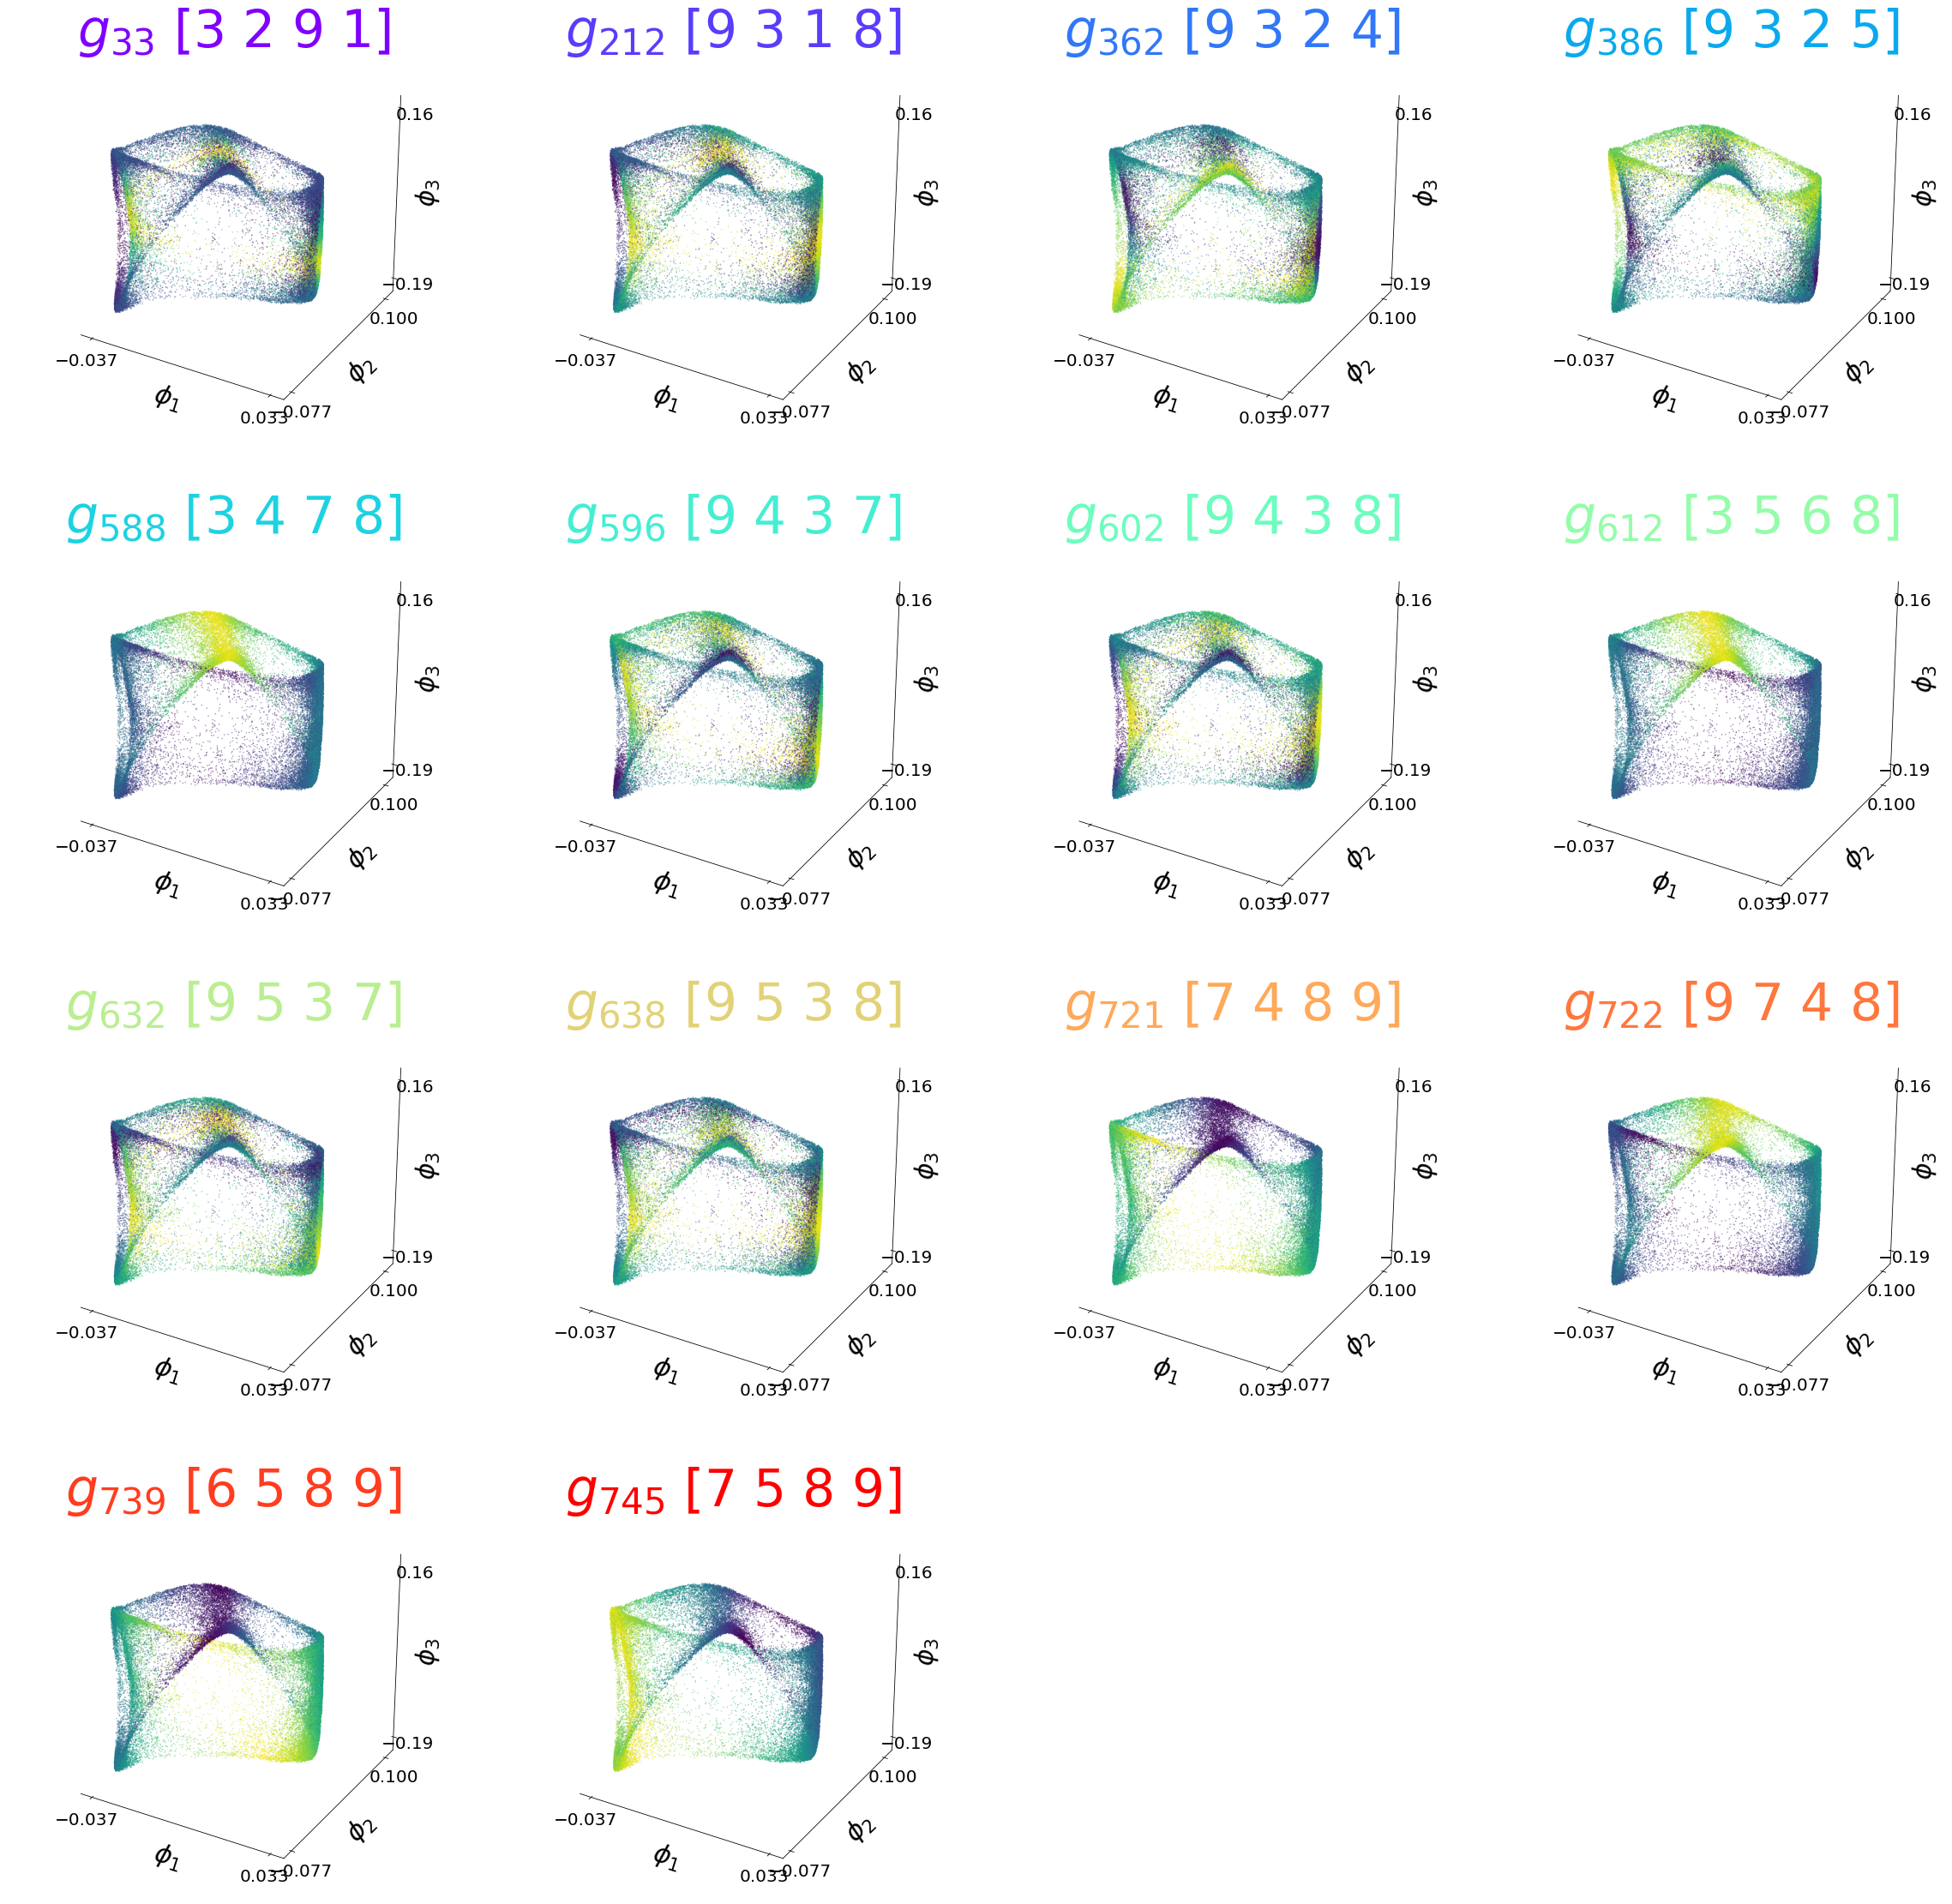

In [19]:
%matplotlib inline
sub = subset_brute
colors = colors_brute
nb = len(sub)
data = experiment.N.data

axes = [0,1,2]
s = 100
alpha = .5

fig, axs = plt.subplots(math.floor(nb / 4) + 1,4, figsize = (40, 10 *( math.floor(nb / 4) + 1),))

for r in range((math.floor(nb / 4)+1 )* 4):
    axs[math.floor(r / 4), r %4 ].set_axis_off()
    
data = experiment.N.data
axes = [0,1,2]
s = 1
alpha = .5
selected_points = list(range(50000))
x = data[:, 0][selected_points]
y = data[:, 1][selected_points]
z = data[:, 2][selected_points]
for r in range(nb):
    print(math.floor(r / 4)+1, r %4+1 ,r+1)
    ax = fig.add_subplot(math.floor(nb / 4)+1, 4 ,r+1, projection='3d')
    #fig = plt.figure(figsize=(15,10))
    #ax = fig.add_subplot(1, 1, 1, projection='3d')
    ax.scatter(x, y, z, c = gb[r], s=s, alpha=alpha, marker='.',vmin=0,vmax=np.pi)
    ax.set_xlabel(r'$\phi_1$', fontsize = 30)
    ax.set_ylabel(r'$\phi_2$', fontsize = 30)
    ax.set_zlabel(r'$\phi_3$', fontsize = 30)
    ax.set_title(r'$g_{{{}}}$'.format(sub[r]) + ' ' + str(experiment.atoms4[sub[r]]+1), fontsize = 60, color = colors[r])
    #ax.set_axis_off()
    xmin = np.float(np.format_float_positional(data[:, 0][selected_points].min(), precision=2, fractional=False))
    xmax = np.float(np.format_float_positional(data[:, 0][selected_points].max(), precision=2, fractional=False))
    ymin = np.float(np.format_float_positional(data[:, 1][selected_points].min(), precision=2, fractional=False))
    ymax = np.float(np.format_float_positional(data[:, 1][selected_points].max(), precision=2, fractional=False))
    zmin = np.float(np.format_float_positional(data[:, 2][selected_points].min(), precision=2, fractional=False))
    zmax = np.float(np.format_float_positional(data[:, 2][selected_points].max(), precision=2, fractional=False))
    ax.set_xticks([xmin, xmax])
    ax.set_yticks([ymin, ymax])
    ax.set_zticks([zmin, zmax])
    ax.tick_params(labelsize=20)

    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    # make the grid lines transparent
    ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)
#plt.savefig('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/Figures/figure_for_jmlr/eth_brute_gs')

In [ ]:
# gmf= {}
# for b in range(len(subset_l0)):
#     print(b)
#     gmf[b] = experiment.get_g_full_sub(experiment.M.data, experiment.atoms4[subset_l0[b]])
    
# with open('/Users/samsonkoelle/manifoldflasso_jmlr/untracked_data/embeddings/ethanol/ethanol_0223_fullreplicates_mfg.pkl' ,
#          'wb') as file:
#      pickle.dump(gmf, file)


In [20]:
with open('/Users/samsonkoelle/manifoldflasso_jmlr/untracked_data/embeddings/ethanol/ethanol_0223_fullreplicates_mfg.pkl' ,
         'rb') as file:
     gmf = pickle.load( file)

In [24]:
with open('/Users/samsonkoelle/manifoldflasso_jmlr/untracked_data/embeddings/ethanol/ethanol_0219_full_mflasso.pkl' ,
         'rb') as file:
     sel = pickle.load(file)
        
subset_l0 = np.unique(np.concatenate(list(sel.values())) )
toplot_l0 = get_support_indices2d(subset_l0, sel,nreps)
names_l0 = get_names(subset_l0)
colors_l0 = get_cmap(subset_l0)

0
1
2
3
4
5
6
7
8
9
10
11
12
13


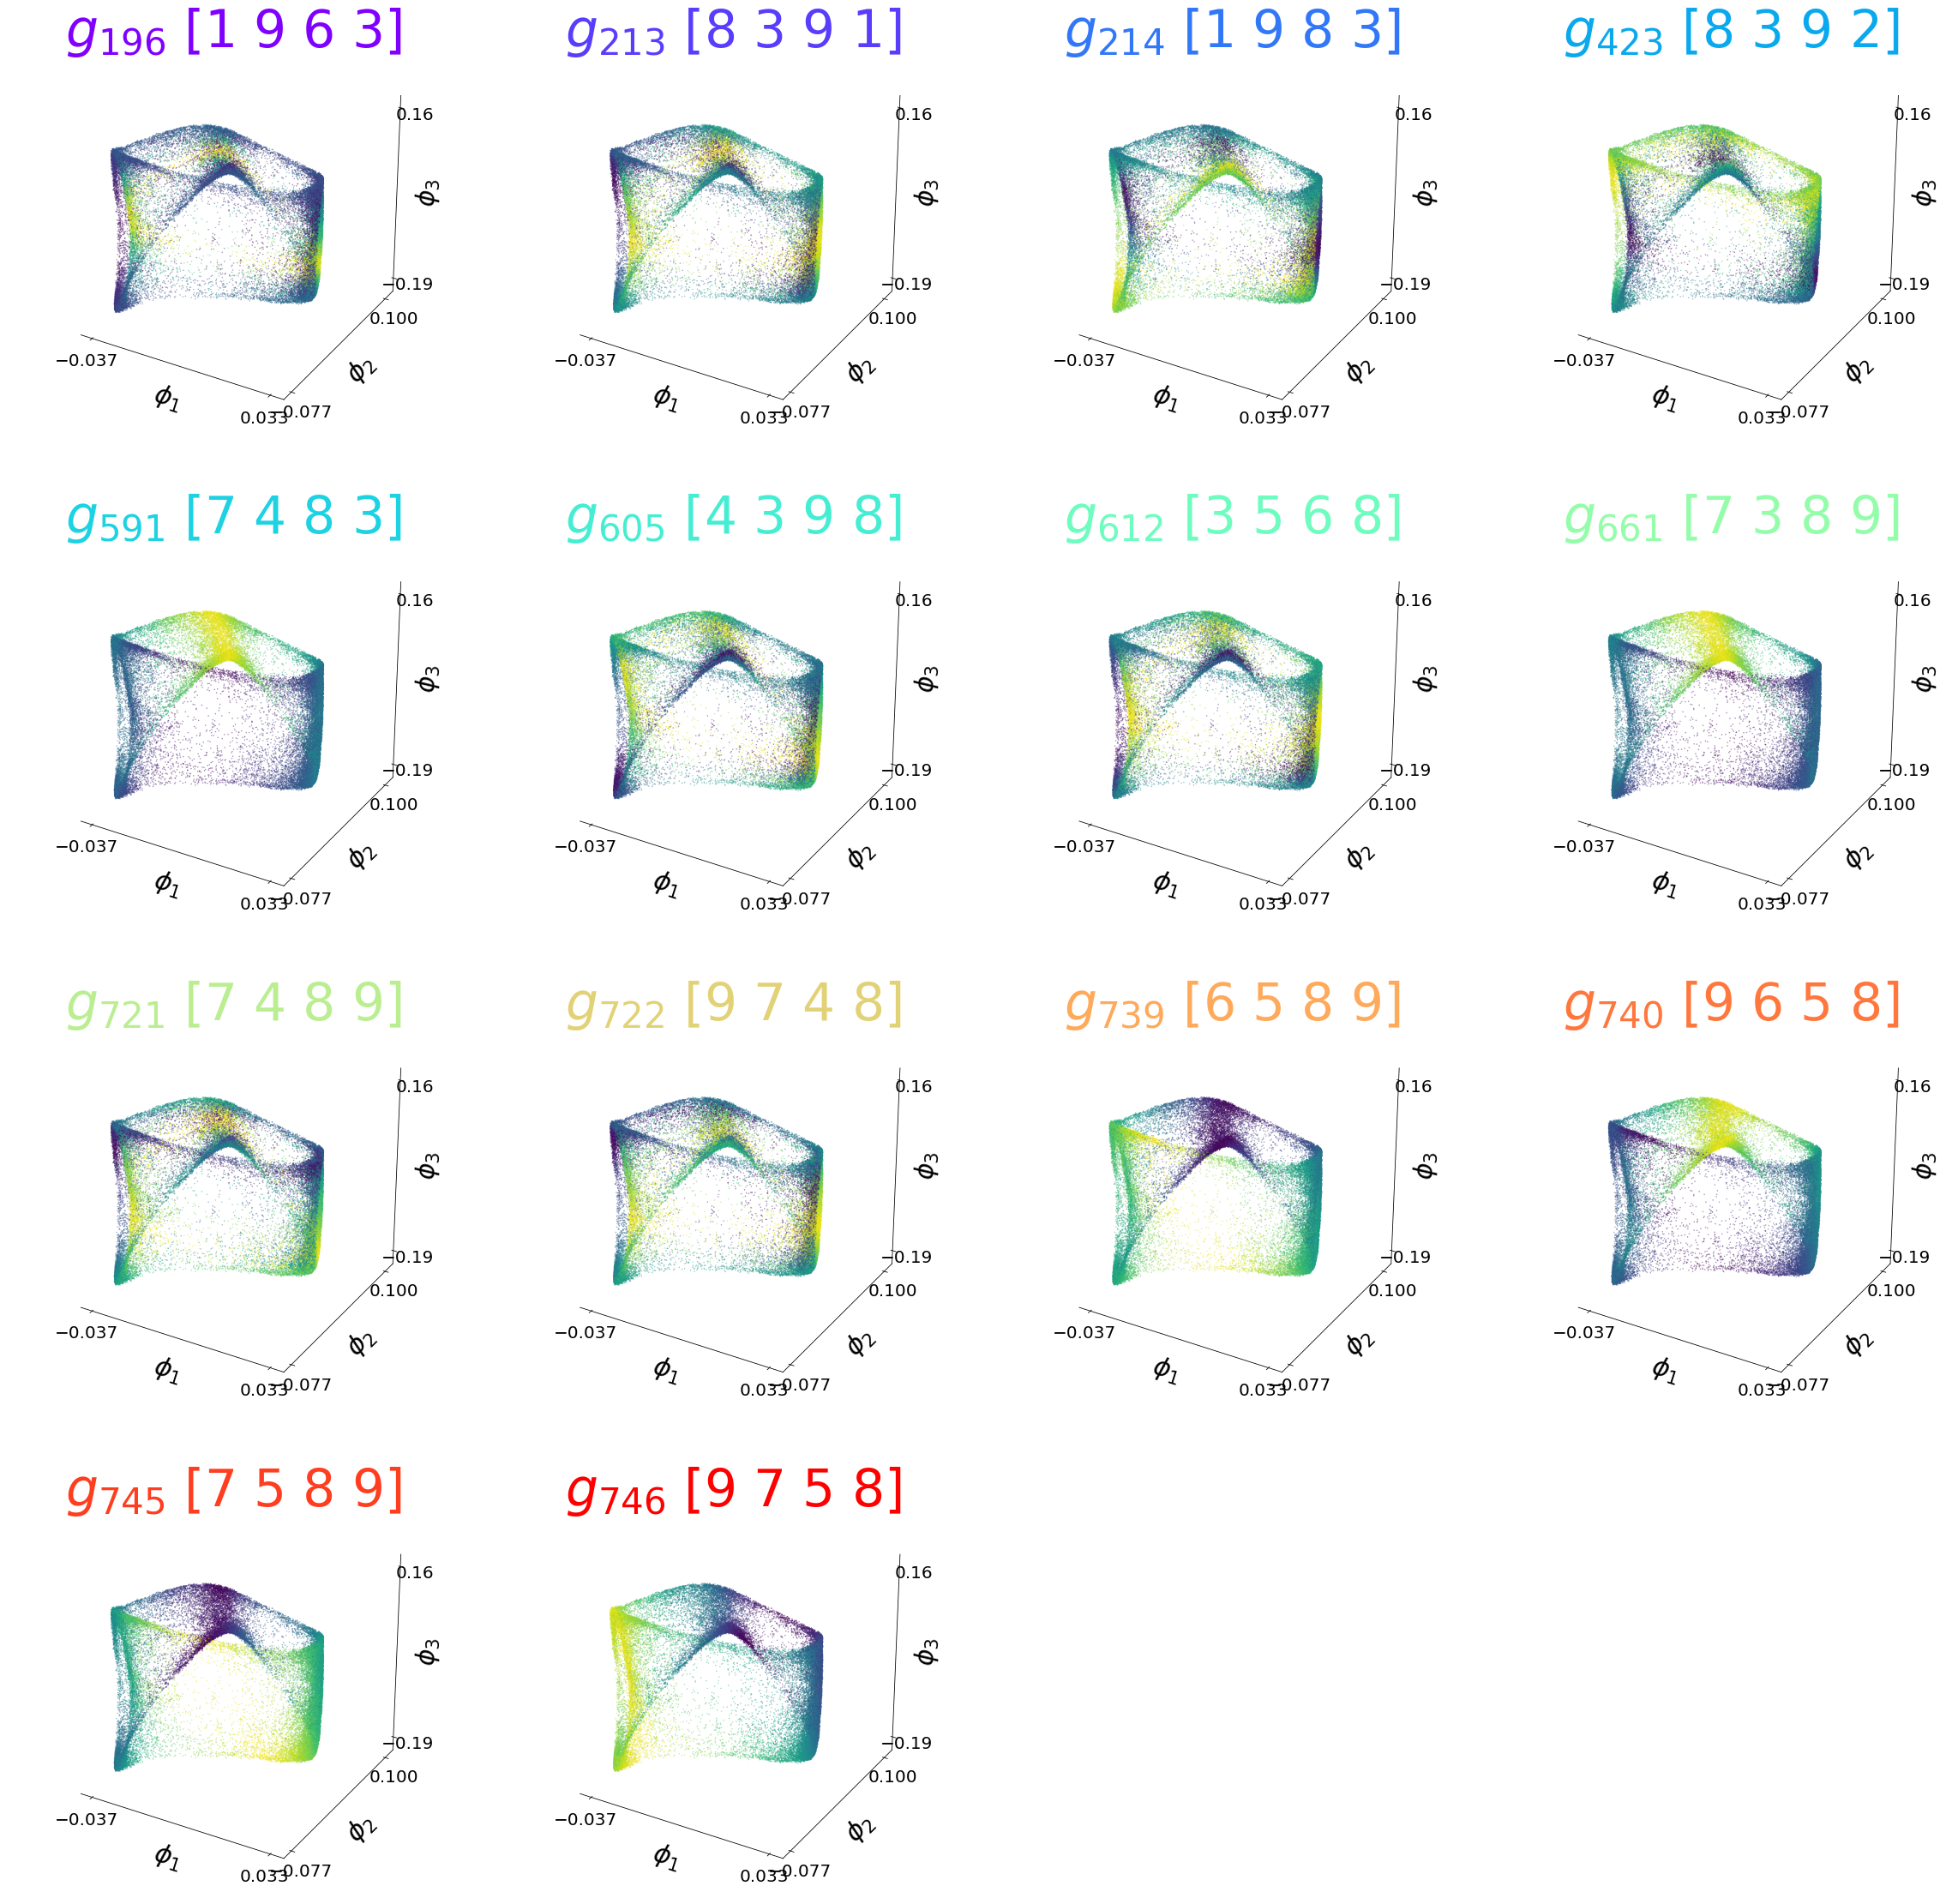

In [25]:
%matplotlib inline
sub = subset_l0
colors = colors_l0
nb = len(sub)
data = experiment.N.data
axes = [0,1,2]
s = 100
alpha = .5

fig, axs = plt.subplots(math.floor(nb / 4) + 1,4, figsize = (10 *( math.floor(nb / 4) + 1),40))

for r in range((math.floor(nb / 4)+1 )* 4):
    axs[math.floor(r / 4), r %4 ].set_axis_off()
    
data = experiment.N.data
axes = [0,1,2]
s = 1
alpha = .5
selected_points = list(range(50000))
x = data[:, 0][selected_points]
y = data[:, 1][selected_points]
z = data[:, 2][selected_points]
for r in range(nb):
    print(r)
    ax = fig.add_subplot(math.floor(nb / 4)+1, 4 ,r+1, projection='3d')
    #ax = fig.add_subplot(nb,1, r+1, projection='3d')
    #fig = plt.figure(figsize=(15,10))
    #ax = fig.add_subplot(1, 1, 1, projection='3d')
    ax.scatter(x, y, z, c = gb[r], s=s, alpha=alpha, marker='.',vmin=0,vmax=np.pi)
    ax.set_xlabel(r'$\phi_1$', fontsize = 30)
    ax.set_ylabel(r'$\phi_2$', fontsize = 30)
    ax.set_zlabel(r'$\phi_3$', fontsize = 30)
    ax.set_title(r'$g_{{{}}}$'.format(sub[r]) + ' ' + str(experiment.atoms4[sub[r]]+1), fontsize = 60, color = colors[r])
    #ax.set_axis_off()
    xmin = np.float(np.format_float_positional(data[:, 0][selected_points].min(), precision=2, fractional=False))
    xmax = np.float(np.format_float_positional(data[:, 0][selected_points].max(), precision=2, fractional=False))
    ymin = np.float(np.format_float_positional(data[:, 1][selected_points].min(), precision=2, fractional=False))
    ymax = np.float(np.format_float_positional(data[:, 1][selected_points].max(), precision=2, fractional=False))
    zmin = np.float(np.format_float_positional(data[:, 2][selected_points].min(), precision=2, fractional=False))
    zmax = np.float(np.format_float_positional(data[:, 2][selected_points].max(), precision=2, fractional=False))
    ax.set_xticks([xmin, xmax])
    ax.set_yticks([ymin, ymax])
    ax.set_zticks([zmin, zmax])
    ax.tick_params(labelsize=20)

    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    # make the grid lines transparent
    ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)
#plt.savefig('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/Figures/figure_for_jmlr/eth_mf_gs')